# <div align="center">Trabalho Final </div>
# <div align="center">Inferência Estatística </div> 


### Grupo.
#### Aluno: Renan Lemes Leepkaln
#### Aluno: Valdiclei Costa Marinho

## <div align="center">Exercício 1</div>

##### Utilizar a base  “ocd_patient_dataset.csv” é um conjunto dedados de pacientes com TOC que possui dados demográficos e clínicos quecontém informações abrangentes sobre 1.500 indivíduos com diagnóstico detranstorno obsessivo-compulsivo (TOC). Observação: o conjunto de dados é inteiramente fictício e não deve ser usado para quaisquer fins clínicos ou de pesquisa reais. Use um nível de significância de 5% para testar a afirmativa de que existe diferença no Score (Pontuação) Y-BOCS (Obsessões) entre pacientes dos sexo feminino e masculino. Com base neste resultado, podemos concluir que existe diferença?

#### <div align="center">**Hipóteses:**</div>
$$
    H_0 : \mu_{female} - \mu_{male} = 0 \newline 
    H_1 : \mu_{female} - \mu_{male} \neq 0
$$

In [2]:
## Libs para tratamento de dados
import pandas as pd
import numpy as np

## Libs para Analise
from scipy.stats import norm, skew
from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu, chi2_contingency,kruskal
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd


## Libs para graficos
import matplotlib.pyplot as plt

plt.style.use("default")
import seaborn as sns

## Lib para ignorar os aviso
import warnings

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("ocd_patient_dataset.csv", sep=",")

data.head()

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,None,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,None


In [4]:
## Pegando apenas Sexo e Score 
df = pd.DataFrame(data[["Gender", "Y-BOCS Score (Obsessions)"]])

In [5]:
df.shape

(1500, 2)

In [6]:
df.describe()

,Y-BOCS Score (Obsessions)
count,1500.000000
mean,20.048000
std,11.823884
min,0.000000
25%,10.000000
50%,20.000000
75%,31.000000
max,40.000000


In [7]:
## Verificando se tem valor nulo e vendo em %
df.isnull().sum().sort_index() / len(df)

Gender                       0.0
Y-BOCS Score (Obsessions)    0.0
dtype: float64

In [8]:
## Vereficando se tem valores NaN em %
df.isna().sum().sort_index() / len(df)

Gender                       0.0
Y-BOCS Score (Obsessions)    0.0
dtype: float64

In [9]:
(df["Y-BOCS Score (Obsessions)"] < 0).sum()

0

In [10]:
df["Gender"].unique()

array(['Female', 'Male'], dtype=object)

In [11]:
tabela_frequencia = df["Gender"].value_counts().reset_index()
tabela_frequencia.columns = ["Valor", "Frequência"]
tabela_frequencia = tabela_frequencia.sort_values(by="Valor")
tabela_frequencia

,Valor,Frequência
1,Female,747
0,Male,753


In [12]:
escores_female = df[df["Gender"] == "Female"]["Y-BOCS Score (Obsessions)"]
escores_male = df[df["Gender"] == "Male"]["Y-BOCS Score (Obsessions)"]

In [13]:
display(escores_female.to_frame().head(), escores_male.to_frame().head())

,Y-BOCS Score (Obsessions)
0,17
3,14
4,39
5,26
6,12


,Y-BOCS Score (Obsessions)
1,21
2,3
7,31
8,37
15,17


### <div align="center">Análise de ajuste de uma distribuição normal </div>

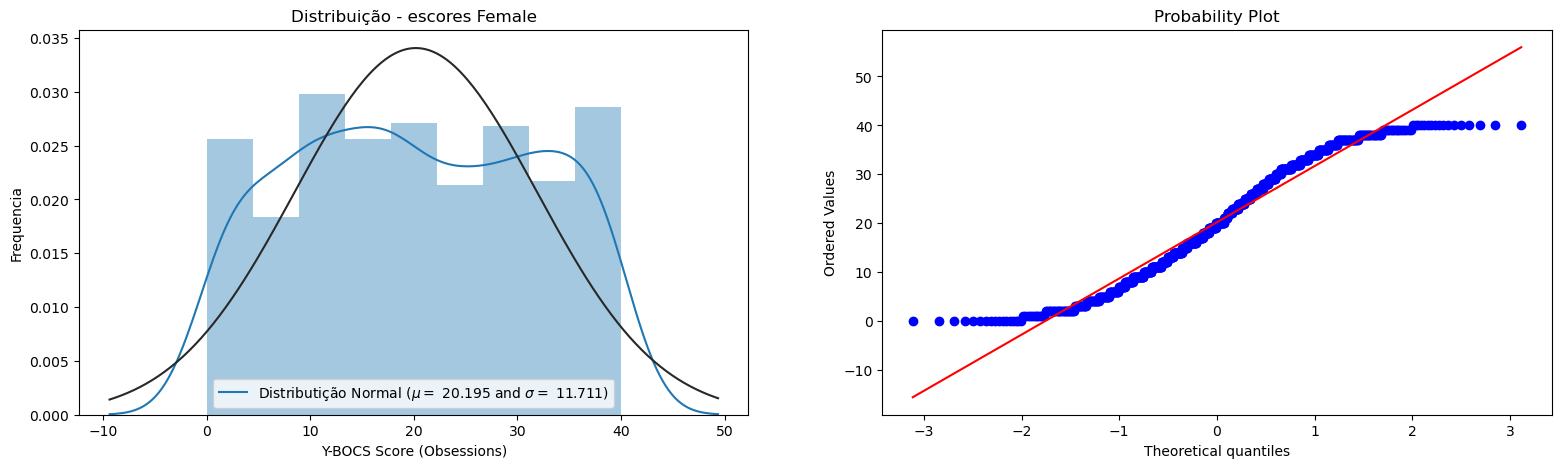

In [14]:
(mu, sigma) = norm.fit(escores_female)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))

ax1 = sns.distplot(escores_female, fit=norm, ax=ax1)
ax1.legend(
    [f"Distributição Normal ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})"], loc="best"
)
ax1.set_ylabel("Frequencia")
ax1.set_title(f"Distribuição - escores Female")

# Usando probplot para o gráfico de probabilidade
stats.probplot(escores_female, plot=ax2)
f.show()

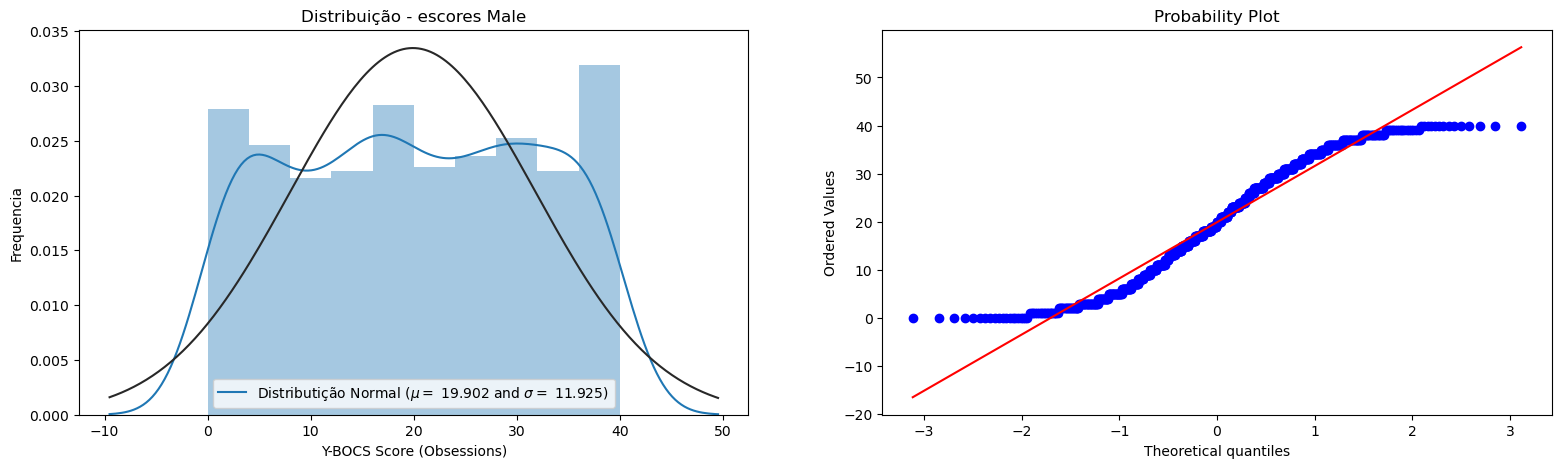

In [15]:
(mu, sigma) = norm.fit(escores_male)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))

ax1 = sns.distplot(escores_male, fit=norm, ax=ax1)
ax1.legend(
    [f"Distributição Normal ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})"], loc="best"
)
ax1.set_ylabel("Frequencia")
ax1.set_title(f"Distribuição - escores Male")

# Usando probplot para o gráfico de probabilidade
stats.probplot(escores_male, plot=ax2)
f.show()

### <div align="center">Teste de Normalidade e Homogeneidade </div>

In [16]:
# Teste de Shapiro para normalizada
_, p_valor_feminino = shapiro(escores_female)
_, p_valor_masculino = shapiro(escores_male)

# Teste de Levene para homogeneidade das variâncias
_, p_valor_variancias = levene(escores_female, escores_male)

print(
    f"p_valor_feminino: {p_valor_feminino}, p_valor_masculino: {p_valor_masculino}, p_valor_variancias: {p_valor_variancias}"
)

# Avaliação de pressupostos (normalidade e homogeneidade das variâncias)
if p_valor_feminino > 0.05 and p_valor_masculino > 0.05 and p_valor_variancias > 0.05:
    # Realizar o teste t de Student
    resultado_teste_t, valor_p = ttest_ind(escores_female, escores_male)

    # Exibir o resultado do teste
    print(
        f'Teste t de Student: {"Diferença significativa" if valor_p < nivel_significancia else "Sem diferença significativa"}'
    )
    print(f"Estatísticas: {resultado_teste_t}, Valor p: {valor_p}")
else:
    print(
        "Os pressupostos para o teste t de Student não foram atendidos. Seguir com teste não paramétrico."
    )

p_valor_feminino: 2.3539514860449785e-14, p_valor_masculino: 3.466535911472138e-15, p_valor_variancias: 0.46910653120857493
Os pressupostos para o teste t de Student não foram atendidos. Seguir com teste não paramétrico.


### <div align="center">Teste de Mann-Whitney U: </div>

Não assume uma distribuição específica para os dados.

In [17]:
# Teste de Mann-Whitney U
estatisticas, valor_p = mannwhitneyu(escores_female, escores_male)

nivel_significancia = 0.05

print(
    f'Teste de Mann-Whitney U: {"Diferença significativa" if valor_p < nivel_significancia else "Sem diferença significativa"}'
)
print(f"Estatísticas: {estatisticas}, Valor p: {valor_p}")

Teste de Mann-Whitney U: Sem diferença significativa
Estatísticas: 285168.0, Valor p: 0.6399821232917488


**Resposta** : $\newline$
Com base nos resultados do teste de Mann-Whitney U, não há evidência estatística suficiente para afirmar que há uma diferença significativa nos escores entre os grupos feminino e masculino.

-----

## <div align="center">Exercício 2</div>

##### O conjunto de dados “Sleep_health_and_lifestyle_dataset.csv” compreende 400 linhas e 13 colunas, cobrindo uma ampla gama de variáveis relacionadas ao sono e hábitos diários. Inclui detalhes como sexo, idade, ocupação, duração do sono, qualidade do sono, nível de atividade física, níveis de estresse, categoria de IMC, pressão arterial, frequência cardíaca, passos diários e presença ou ausência do distúrbio do sono (Insônia). O nosso objetivo é avaliar se existe diferença na proporção de pessoas que possuem ou não o distúrbio do sono (Insônia) para as diferenças ocupações na base de dados. Use o nível de significância de 5% e caso encontre diferenças, relate em quais das ocupações vemos essa diferença significativa.

*Objetivo*:  
Avaliar se existe diferença na proporção de pessoas que possuem ou não o distúrbio do sono (Insônia) para as diferenças ocupações na base de dados. Use o nível de significância de 5% e caso encontre diferenças, relate em quais das ocupações vemos essa diferença significativa.

#### <div align="center">**Hipóteses:**</div>
$$
    H_0 : \text{as proporções de pessoas com e sem insônia são iguais para todas as ocupações.} \newline 
    H_1 : \text{as proporções de pessoas com e sem insônia são diferentes para pelo menos uma ocupação.}
$$

In [18]:
data2 = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", sep=",")
data2.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No
1,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No
2,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
3,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,No
4,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,No


In [19]:
df = pd.DataFrame(data2[["Occupation", "Sleep Disorder"]])
df.head()

,Occupation,Sleep Disorder
0,Doctor,No
1,Doctor,No
2,Teacher,Insomnia
3,Doctor,No
4,Doctor,No


In [20]:
df.describe()

,Occupation,Sleep Disorder
count,289,289
unique,7,2
top,Doctor,No
freq,67,213


In [21]:
df.isnull().sum().sort_index() / len(df)

Occupation        0.0
Sleep Disorder    0.0
dtype: float64

In [22]:
df.isna().sum().sort_index() / len(df)

Occupation        0.0
Sleep Disorder    0.0
dtype: float64

In [23]:
df["Occupation"].unique()

array(['Doctor', 'Teacher', 'Nurse', 'Engineer', 'Accountant', 'Lawyer',
       'Salesperson'], dtype=object)

In [24]:
df["Sleep Disorder"].unique()

array(['No', 'Insomnia'], dtype=object)

In [25]:
tabela_frequencia_occup = df["Occupation"].value_counts().reset_index()
tabela_frequencia_occup.columns = ["Valor", "Frequência"]
tabela_frequencia_occup = tabela_frequencia_occup.sort_values(by="Valor")
print(tabela_frequencia_occup)

         Valor  Frequência
3   Accountant          37
0       Doctor          67
1     Engineer          62
2       Lawyer          44
6        Nurse          12
5  Salesperson          31
4      Teacher          36


In [26]:
tabela_frequencia_slp = df["Sleep Disorder"].value_counts().reset_index()
tabela_frequencia_slp.columns = ["Valor", "Frequência"]
tabela_frequencia_slp = tabela_frequencia_slp.sort_values(by="Valor")
print(tabela_frequencia_slp)

      Valor  Frequência
1  Insomnia          76
0        No         213


In [27]:
# Tabela de contingência
contingency_table = pd.crosstab(df["Sleep Disorder"], df["Occupation"])
contingency_table

Occupation,Accountant,Doctor,Engineer,Lawyer,Nurse,Salesperson,Teacher
Sleep Disorder,,,,,,,
Insomnia,7,3,5,2,3,29,27
No,30,64,57,42,9,2,9


## Aplicação do teste qui-quadrado para independência 

Apropriada quando se trabalha com variáveis categóricas e deseja-se avaliar se a ocorrência de uma categoria em uma variável é independente da ocorrência de uma categoria em outra variável. 

In [28]:
# Tabela de contingência
contingency_table = pd.crosstab(df["Sleep Disorder"], df["Occupation"])

# Verifica frequencias esperadas
expected_frequencies = chi2_contingency(contingency_table)[3]

if (expected_frequencies < 1).any():
    print("Algumas células têm frequências esperadas abaixo de 1")

# Teste qui-quadrado de independência (Variáveis categoricas)
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("Há uma diferença significativa nas proporções entre as ocupações.\n")

    # Se houver uma diferença significativa calculamos as proporções de insônia em cada ocupação.
    proportions = (df.groupby("Occupation")["Sleep Disorder"].value_counts(normalize=True).unstack())
    print(proportions)
else:
    print(
        "Não há evidências de diferença significativa nas proporções entre as ocupações."
    )

Chi-square statistic: 155.27672811256065
P-value: 5.9210138109735935e-31
Há uma diferença significativa nas proporções entre as ocupações.

Sleep Disorder  Insomnia        No
Occupation                        
Accountant      0.189189  0.810811
Doctor          0.044776  0.955224
Engineer        0.080645  0.919355
Lawyer          0.045455  0.954545
Nurse           0.250000  0.750000
Salesperson     0.935484  0.064516
Teacher         0.750000  0.250000


**Resposta** : $\newline$
Sim há uma diferença significativa nas proporções entre as ocupações.

----

## <div align="center">Exercício 3</div>

##### Uma empresa de tecnologia está constantemente analisando o mercado e buscando novas formas de converter os clientes (fechar contratos). Pensando nisso, ela investiu em uma empresa de treinamento de vendedores (VendaPro Academy) que diz que o seu método de vendas é superior aos métodos convencionais. Para verificar essa hipótese, a empresa de tecnologia vai avaliar o desempenho dos funcionários. Vamos comparar o desempenho de 35 vendedores ao utilizar o método convencional de vendas e o método obtido pelo treinamento com a empresa VendaPro Academy, medindo o tempo de trabalho em horas necessário para alcançar uma meta de 10 contratos vendidos. Os dados estão na base de dados “treinamentoVendedores.csv”. Determine ao nível de 2% de significância, se o método da empresa VendaPro Academy é realmente superior ao método convencional da empresa.

*Objetivo*: Determine ao nível de 2% de significância, se o método da empresa VendaPro Academy é realmente superior ao método convencional da empresa.

#### <div align="center">**Hipóteses:**</div>
$$
    H_0 : \overline{x}_1 - \overline{x}_2 = 0 \newline
    H_1 : \overline{x}_1 - \overline{x}_2 > 0
$$
$$
    H_0 : \text{Não há diferença significativa entre as médias das duas amostras.} \newline 
    H_1 : \text{Há uma diferença significativa entre as médias das duas amostras. }
$$

In [29]:
data3 = pd.read_csv("treinamentoVendedores.csv", sep=",")
data3.head()
df = data3.copy()
df.head()

,Funcionário,Convencional,VendaPro
0,1,52.483571,38.895782
1,2,49.308678,46.044318
2,3,53.238443,35.201649
3,4,57.615149,38.359070
4,5,48.829233,45.984306


### Aplicação de teste t pareado

Apropriado quando você temos pares de observações relacionadas (no caso, os tempos de trabalho para cada funcionário nos dois métodos). 

**Avaliação dos pressupostos:**

**1. normalidade das diferenças**

In [30]:
# Shapiro
_, normalidade_p_value = stats.shapiro(df["Convencional"] - df["VendaPro"])

# Nível de significância
alpha = 0.05

# Avaliação da normalidade das diferenças
if normalidade_p_value > alpha:
    print(
        "A diferença entre os métodos tem uma distribuição normal (não rejeita H0 de normalidade)."
    )
else:
    print(
        "A diferença entre os métodos não tem uma distribuição normal (rejeita H0 de normalidade)."
    )

A diferença entre os métodos tem uma distribuição normal (não rejeita H0 de normalidade).


**2. homogeneidade das variâncias das diferenças**

In [31]:
# levene
homogeneidade_p_value = stats.levene(df["Convencional"], df["VendaPro"]).pvalue

# Nível de significância
alpha = 0.05

# Avaliação da homogeneidade das variâncias das diferenças
if homogeneidade_p_value > alpha:
    print(
        "As variâncias das diferenças são homogêneas (não rejeita H0 de homogeneidade de variâncias)."
    )
else:
    print(
        "As variâncias das diferenças não são homogêneas (rejeita H0 de homogeneidade de variâncias)."
    )

As variâncias das diferenças são homogêneas (não rejeita H0 de homogeneidade de variâncias).


### Realização do teste t pareado após os pressupostos serem atendidos

In [32]:
if normalidade_p_value > alpha and homogeneidade_p_value > alpha:
    t_statistic, p_value = stats.ttest_rel(df["Convencional"], df["VendaPro"])

    # Verifica a significância estatística
    if p_value < alpha:
        print(
            "Rejeita a hipótese nula. Existe evidência estatística de que o método VendaPro Academy é superior ao método convencional."
        )
    else:
        print(
            "Não há evidência estatística suficiente para rejeitar a hipótese nula. Não podemos afirmar que um método é superior ao outro."
        )
else:
    print(
        "Não é apropriado realizar o teste t pareado devido às violações dos pressupostos."
    )

Rejeita a hipótese nula. Existe evidência estatística de que o método VendaPro Academy é superior ao método convencional.


**Resposta** : $\newline$
Por tanto o método VendaPro e melhor que o método convencional.

----

## <div align="center">Exercício 4</div>

##### Em um mundo onde a música desempenha um papel fundamental nas experiências diárias, a imersão em uma variedade de gêneros musicais tornou-se uma parte intrínseca da vida cotidiana. Com a ascensão de plataformas de streaming e a facilidade de acesso à música, as pessoas desfrutam da liberdade de escolher seus gêneros preferidos e dedicar tempo considerável à apreciação das composições que ressoam com suas emoções. Este fenômeno despertou um interesse significativo em compreender o tempo dedicado diariamente às músicas favoritas das pessoas, bem como explorar se existem diferenças notáveis nos hábitos de escuta entre os diversos gêneros musicais. No conjunto de dados "Musicas.csv", encontramos informações detalhadas sobre usuários de várias idades, incluindo dados sobre seus hábitos musicais, como o gênero favorito e o tempo diário dedicado à audição musical. O objetivo central deste estudo é testar a hipótese de que existe uma diferença significativa no tempo, em horas, que as pessoas dedicam diariamente à audição de música, com base em seus gêneros musicais favoritos. Use as colunas: (Fav genre - gênero favorito e Hours per day - horas por dia). Use o nível de significância de 5% para verificar essa hipótese.

*Objetivo*: O objetivo central deste estudo é testar a hipótese de que existe uma diferença significativa no tempo, em horas, que as pessoas dedicam diariamente à audição de música, com base em seus gêneros musicais favoritos. Utilizar o nível de significância de 5% para verificar essa hipótese.

#### <div align="center">**Hipóteses:**</div>

$$
    H_0 : \text{Não há diferença significativa no tempo médio dedicado à audição de música entre os diferentes gêneros musicais.} \newline 
    H_1 : \text{Existe uma diferença significativa no tempo médio dedicado à audição de música entre os diferentes gêneros musicais}
$$

In [33]:
data4 = pd.read_csv("Musicas.csv", sep=",")
data4.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
1,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
2,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.
3,8/27/2022 22:00:29,18.0,YouTube Music,3.0,Yes,Yes,No,Video game music,Yes,Yes,...,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,Improve,I understand.
4,8/27/2022 22:18:59,21.0,Spotify,1.0,Yes,No,No,K pop,Yes,Yes,...,Sometimes,Rarely,Never,Rarely,5.0,3.0,5.0,3.0,Improve,I understand.


In [34]:
df = pd.DataFrame(data4[["Fav genre", "Hours per day"]])
df.head()

,Fav genre,Hours per day
0,Rock,1.5
1,Video game music,4.0
2,R&B,4.0
3,Video game music,3.0
4,K pop,1.0


In [35]:
df.isnull().sum().sort_index() / len(df)

Fav genre        0.0
Hours per day    0.0
dtype: float64

In [36]:
df.isna().sum().sort_index() / len(df)

Fav genre        0.0
Hours per day    0.0
dtype: float64

In [37]:
df["Fav genre"].unique()

array(['Rock', 'Video game music', 'R&B', 'K pop', 'Country', 'EDM',
       'Hip hop', 'Pop', 'Rap', 'Classical', 'Metal', 'Folk'],
      dtype=object)

In [38]:
df["Hours per day"].unique()

array([ 1.5 ,  4.  ,  3.  ,  1.  ,  6.  ,  8.  ,  2.  , 12.  , 24.  ,
        5.  ,  0.5 ,  0.25,  0.  ,  7.  , 10.  ,  2.5 ,  9.  ,  0.7 ,
        4.5 , 20.  , 15.  , 14.  , 13.  ,  0.1 , 11.  , 18.  ])

In [39]:
tabela_frequencia_FavGenre = df["Fav genre"].value_counts().reset_index()
tabela_frequencia_FavGenre.columns = ["Valor", "Frequência"]
tabela_frequencia_FavGenre = tabela_frequencia_FavGenre.sort_values(by="Valor")
tabela_frequencia_FavGenre.head()

,Valor,Frequência
3,Classical,53
10,Country,25
5,EDM,37
8,Folk,30
7,Hip hop,35


In [40]:
tabela_frequencia_Hours = df["Hours per day"].value_counts().reset_index()
tabela_frequencia_Hours.columns = ["Valor", "Frequência"]
tabela_frequencia_Hours = tabela_frequencia_Hours.sort_values(by="Valor")
tabela_frequencia_Hours.head()

,Valor,Frequência
12,0.00,6
23,0.10,1
16,0.25,2
7,0.50,20
18,0.70,1


**Shapiro-Wilk para normalidade por grupo de gênero musical**

In [41]:
# Shapiro-Wilk para normalidade por grupo de gênero musical
for genre in df["Fav genre"].unique():
    print(genre)
    print("--------------------------------------------------")
    genre_data = df[df["Fav genre"] == genre]["Hours per day"]
    stat, p_value = shapiro(genre_data)
    print(f"Shapiro-Wilk Test for {genre} : p-value: {p_value}")
    if p_value > 0.05:
        print(f"Os dados de {genre}: parecem seguir uma distribuição normal.")
    else:
        print(f"Os dados de {genre}: não seguem uma distribuição normal.\n")

Rock
--------------------------------------------------
Shapiro-Wilk Test for Rock : p-value: 2.0905416353880454e-16
Os dados de Rock: não seguem uma distribuição normal.

Video game music
--------------------------------------------------
Shapiro-Wilk Test for Video game music : p-value: 1.3959829630039167e-05
Os dados de Video game music: não seguem uma distribuição normal.

R&B
--------------------------------------------------
Shapiro-Wilk Test for R&B : p-value: 0.00018480031576473266
Os dados de R&B: não seguem uma distribuição normal.

K pop
--------------------------------------------------
Shapiro-Wilk Test for K pop : p-value: 0.00015500000154133886
Os dados de K pop: não seguem uma distribuição normal.

Country
--------------------------------------------------
Shapiro-Wilk Test for Country : p-value: 0.013172503560781479
Os dados de Country: não seguem uma distribuição normal.

EDM
--------------------------------------------------
Shapiro-Wilk Test for EDM : p-value: 2.357

**Levene para homogeneidade das variâncias**

In [42]:
stat, p_value = levene(
    df[df["Fav genre"] == "Rock"]["Hours per day"],
    df[df["Fav genre"] == "Video game music"]["Hours per day"],
    df[df["Fav genre"] == "R&B"]["Hours per day"],
    df[df["Fav genre"] == "K pop"]["Hours per day"],
)
print(f"Levene Test - p-value: {p_value}")
if p_value > 0.05:
    print("As variâncias são homogêneas.")
else:
    print("As variâncias não são homogêneas.")

Levene Test - p-value: 0.48529179962978475
As variâncias são homogêneas.


**Como os dados não seguiram uma distribuição normal, será utilizado um teste Não-Paramétrico: kruskal**

In [43]:
# Kruskal-Wallis para comparar os grupos
h_statistic, p_value = kruskal(
    df[df["Fav genre"] == "Rock"]["Hours per day"],
    df[df["Fav genre"] == "Video game music"]["Hours per day"],
    df[df["Fav genre"] == "R&B"]["Hours per day"],
    df[df["Fav genre"] == "K pop"]["Hours per day"],
)

# Análise dos resultados
print(f"Kruskal-Wallis H-Statistic: {h_statistic:}")
print(f"Kruskal-Wallis p-value: {p_value:}")

if p_value < 0.05:
    print(
        "Rejeitamos a hipótese nula. Há uma diferença significativa nos tempos médios de audição entre os gêneros musicais."
    )
else:
    print(
        "Não há evidências suficientes para rejeitar a hipótese nula. Não há diferença significativa nos tempos médios de audição entre os gêneros musicais."
    )

Kruskal-Wallis H-Statistic: 4.659647402961016
Kruskal-Wallis p-value: 0.19848454803469903
Não há evidências suficientes para rejeitar a hipótese nula. Não há diferença significativa nos tempos médios de audição entre os gêneros musicais.


In [44]:
# Realizando usando a Lib pingouin

result = pg.kruskal(data=df, dv="Hours per day", between="Fav genre")

# Resultados
result

,Source,ddof1,H,p-unc
Kruskal,Fav genre,11,17.024857,0.107142


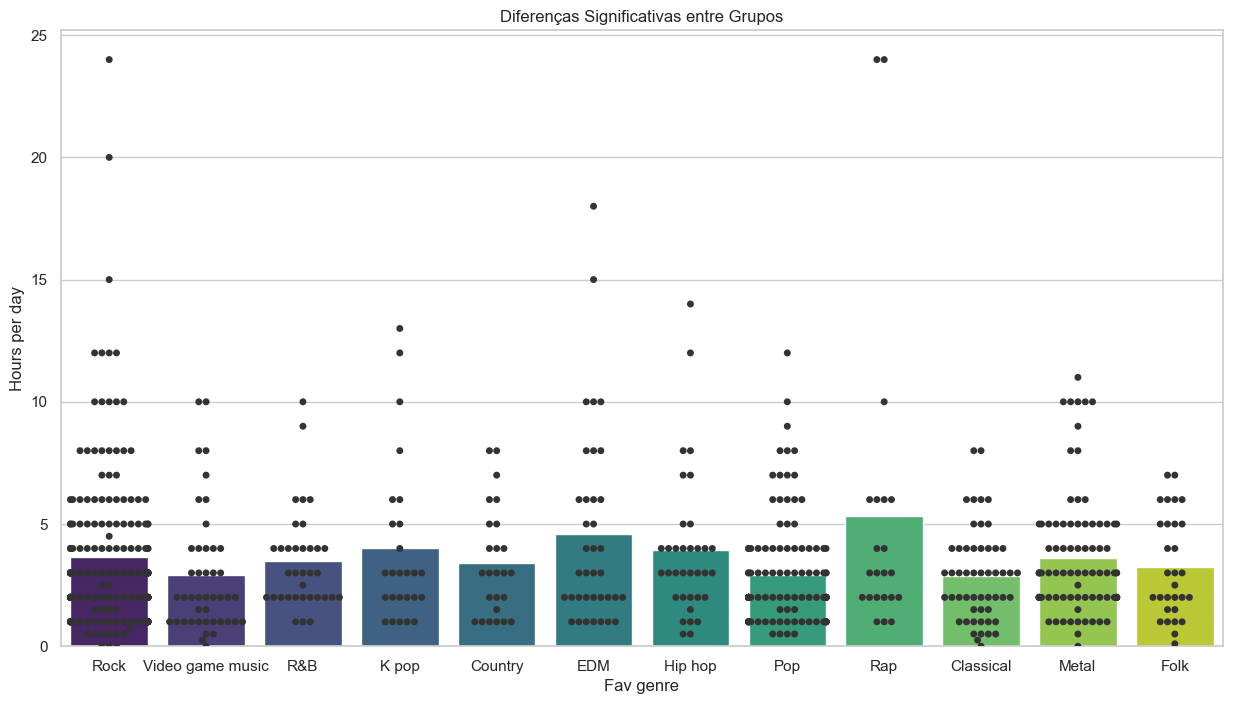

In [45]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.barplot(
    x="Fav genre", y="Hours per day", data=df, ci=None, capsize=0.1, palette="viridis"
)
sns.swarmplot(x="Fav genre", y="Hours per day", data=df, color="0.2")
plt.title("Diferenças Significativas entre Grupos")
plt.show()

**Resposta** : $\newline$
Não há diferença significativa nos tempos médios de audição entre os gêneros musicais.

----

## <div align="center">Exercício 5</div>

##### O sucesso de uma equipe esportiva não se limita apenas às habilidades físicas dos atletas, mas também é influenciado por fatores psicológicos, incluindo o estilo de treinamento adotado pelo treinador. Diferentes treinadores têm abordagens únicas para motivar, orientar e interagir com seus atletas. Pensando nisso, um estudo foi feito durante um ano para explorar o impacto do comportamento do treinador no desempenho de equipes de atletas, para isso, avaliou-se o desempenho de equipes para diferentes tipos de treinadores que treinaram a equipe durante dois meses cada um. A hipótese em teste é que o comportamento do treinador durante o treinamento pode ter um efeito significativo no desempenho das equipes na corrida. Acredita-se que certos tipos de treinadores podem influenciar positivamente os resultados, enquanto outros podem ter diferentes implicações no desempenho dos atletas. Entenda como impacto positivo, uma diminuição no tempo que as equipes levaram para finalizar a corrida. Use a base de dados “Treinador.csv” e conclua se existe essa diferença significativa do comportamento do treinador no tempo de corrida das equipes, use o nível de significância de 5%. Com base nos resultados conseguimos identificar uma diferença? Se sim, entre quais tipos de comportamentos vemos um tempo menor para finalização da corrida?

*Objetivo*: Validar se existe essa diferença significativa do comportamento do treinador no tempo de corrida das equipes, use o nível de significância de 5%. Se sim, entre quais tipos de comportamentos vemos um tempo menor para finalização da corrida?

#### <div align="center">**Hipóteses:**</div>

$$
    H_0 : \text{Não há efeito significativo do comportamento do treinador no desempenho da equipe na corrida.} \newline 
    H_1 : \text{Existe um efeito significativo do comportamento do treinador no desempenho da equipe na corrida.}
$$

In [46]:
data5 = pd.read_csv("ImpactoTreinador.csv", sep=",")
data5.head()

,Equipe,Semana,Tipo de Treinador,Tempo de Corrida
0,1,1,Motivador,42.483571
1,1,1,Rigoroso,46.308678
2,1,1,Colaborador,53.238443
3,1,1,Analítico,47.615149
4,2,1,Motivador,38.829233


In [47]:
df = pd.DataFrame(data5[["Tipo de Treinador", "Tempo de Corrida"]])

In [48]:
df.head()

,Tipo de Treinador,Tempo de Corrida
0,Motivador,42.483571
1,Rigoroso,46.308678
2,Colaborador,53.238443
3,Analítico,47.615149
4,Motivador,38.829233


In [49]:
df.isnull().sum().sort_index() / len(df)

Tempo de Corrida     0.0
Tipo de Treinador    0.0
dtype: float64

In [50]:
df.isna().sum().sort_index() / len(df)

Tempo de Corrida     0.0
Tipo de Treinador    0.0
dtype: float64

In [51]:
df["Tipo de Treinador"].unique()

array(['Motivador', 'Rigoroso', 'Colaborador', 'Analítico'], dtype=object)

**Análise de pressupostos**

In [52]:
# Shapiro-Wilk para normalidade por Tempo de Corrida
for tp_treinador in df["Tipo de Treinador"].unique():
    print(tp_treinador)
    print("--------------------------------------------------")
    treinador_data = df[df["Tipo de Treinador"] == tp_treinador]["Tempo de Corrida"]
    stat, p_value = shapiro(treinador_data)
    print(f"Shapiro-Wilk Test for {tp_treinador} - p-value: {p_value}")
    if p_value > 0.05:
        print(f"Os dados de {tp_treinador} parecem seguir uma distribuição normal.\n")
    else:
        print(f"Os dados de {tp_treinador} não seguem uma distribuição normal.\n")

# Levene para homogeneidade das variâncias
stat, p_value = levene(
    df[df["Tipo de Treinador"] == "Motivador"]["Tempo de Corrida"],
    df[df["Tipo de Treinador"] == "Rigoroso"]["Tempo de Corrida"],
    df[df["Tipo de Treinador"] == "Colaborador"]["Tempo de Corrida"],
    df[df["Tipo de Treinador"] == "Analítico"]["Tempo de Corrida"],
)
print(f"\nLevene Test - p-value: {p_value:.4f}")
if p_value > 0.05:
    print("As variâncias são homogêneas.")
else:
    print("As variâncias não são homogêneas.")

Motivador
--------------------------------------------------
Shapiro-Wilk Test for Motivador - p-value: 0.9863467812538147
Os dados de Motivador parecem seguir uma distribuição normal.

Rigoroso
--------------------------------------------------
Shapiro-Wilk Test for Rigoroso - p-value: 0.06602644920349121
Os dados de Rigoroso parecem seguir uma distribuição normal.

Colaborador
--------------------------------------------------
Shapiro-Wilk Test for Colaborador - p-value: 0.9958397150039673
Os dados de Colaborador parecem seguir uma distribuição normal.

Analítico
--------------------------------------------------
Shapiro-Wilk Test for Analítico - p-value: 0.5084320306777954
Os dados de Analítico parecem seguir uma distribuição normal.


Levene Test - p-value: 0.4352
As variâncias são homogêneas.


**Dado que estamos lidando com mais de dois grupos (tipo de treinador), será realizado a Análise de Variância (ANOVA)**

In [53]:
tempo_motivador = df[df["Tipo de Treinador"] == "Motivador"]["Tempo de Corrida"]
tempo_rigoroso = df[df["Tipo de Treinador"] == "Rigoroso"]["Tempo de Corrida"]
tempo_colaborador = df[df["Tipo de Treinador"] == "Colaborador"]["Tempo de Corrida"]
tempo_analitico = df[df["Tipo de Treinador"] == "Analítico"]["Tempo de Corrida"]

# Realiza o teste t
statistic, p_value = stats.f_oneway(
    tempo_motivador, tempo_rigoroso, tempo_colaborador, tempo_analitico
)

# Nível de significância
alpha = 0.05

# Avalia o valor p
if p_value < alpha:
    print(
        "Rejeitar H0: Há diferença significativa no tempo de corrida entre os tipos de treinadores."
    )
else:
    print(
        "Não rejeitar H0: Não há evidência de diferença significativa no tempo de corrida entre os tipos de treinadores."
    )

Rejeitar H0: Há diferença significativa no tempo de corrida entre os tipos de treinadores.


In [54]:
# Aplica o teste de Tukey para comparações múltiplas
tukey_results = pairwise_tukeyhsd(df["Tempo de Corrida"], df["Tipo de Treinador"])

# Cria um DataFrame com os resultados do teste de Tukey
tukey_df = pd.DataFrame(
    data=tukey_results._results_table.data[1:],
    columns=tukey_results._results_table.data[0],
)

In [55]:
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Analítico,Colaborador,8.7142,0.0000,4.3268,13.1016,True
1,Analítico,Motivador,-1.4272,0.8246,-5.8146,2.9602,False
2,Analítico,Rigoroso,4.0770,0.0775,-0.3104,8.4644,False
3,Colaborador,Motivador,-10.1414,0.0000,-14.5288,-5.7540,True
4,Colaborador,Rigoroso,-4.6372,0.0344,-9.0246,-0.2498,True
5,Motivador,Rigoroso,5.5042,0.0084,1.1168,9.8916,True


In [56]:
tukey_df[tukey_df["reject"] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Analítico,Colaborador,8.7142,0.0000,4.3268,13.1016,True
3,Colaborador,Motivador,-10.1414,0.0000,-14.5288,-5.7540,True
4,Colaborador,Rigoroso,-4.6372,0.0344,-9.0246,-0.2498,True
5,Motivador,Rigoroso,5.5042,0.0084,1.1168,9.8916,True


**Resposta** : $\newline$
* Com base nos resultados, as diferenças entre Colaborador e Rigoroso, Motivador e Rigoroso, Analítico e Colaborador, Colaborador e Motivador são consideradas significativas. 
* Não há evidência suficiente para afirmar uma diferença significativa entre Analítico e Motivador, e Analítico e Rigoroso, embora haja uma tendência para o grupo Analítico e Rigoroso.

----

# Celebrando o Natal e as Festas de Final de Ano 🎄🎉

## 🎅 Mensagem Afestiva

Desejamos a você professora um Feliz Natal e um Próspero Ano Novo! Que esta temporada de festas esteja repleta de alegria, amor e momentos especiais com amigos e familiares. ⭐🎉
